In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import calendar
import itertools

pd.set_option('display.max_columns', 100)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

sns.set_theme(style='darkgrid')

In [37]:
from models import MLP, ConvNet, LSTM
from train_test import train, test
from helpers import pred_to_perf, perf_to_stat, performance_plot, \
                    turnover, annual_alpha_plot_grossnet, annual_alpha_plot, correlation, \
                    pred_to_daily_ret, price_to_perf

# Data

In [4]:
indices_price_excel = pd.read_csv('SW_data/prices.csv', index_col=0, parse_dates=True)
#indices_price_excel = pd.read_excel('SW_data/indices_price.xlsx', parse_dates=True, index_col=0, skiprows=[0,1,2,3,5,6,7])
#indices_price_excel.to_csv('SW_data/prices.csv', index=True)
indices_price_excel.drop(columns=['SMIMC Index'], inplace=True)
indices_price_excel.head()
indices_price_excel.columns = ['SPI', 'MID', 'MID_SMALL', 'LARGE']
indices_price_excel.head()

,SPI,MID,MID_SMALL,LARGE
1996-01-04,2182.67,2049.35,423.28,3395.8
1996-01-05,2175.09,2054.88,424.38,3376.1
1996-01-08,2176.68,2071.98,427.67,3368.1
1996-01-09,2174.13,2077.84,429.26,3361.5
1996-01-10,2149.15,2068.74,426.99,3314.8


In [5]:
bench_price = indices_price_excel['SPI']
price = indices_price_excel[indices_price_excel.columns[1:]]
daily_returns = price.pct_change().dropna()
daily_return_bench = bench_price.pct_change()
price.head()

,MID,MID_SMALL,LARGE
1996-01-04,2049.35,423.28,3395.8
1996-01-05,2054.88,424.38,3376.1
1996-01-08,2071.98,427.67,3368.1
1996-01-09,2077.84,429.26,3361.5
1996-01-10,2068.74,426.99,3314.8


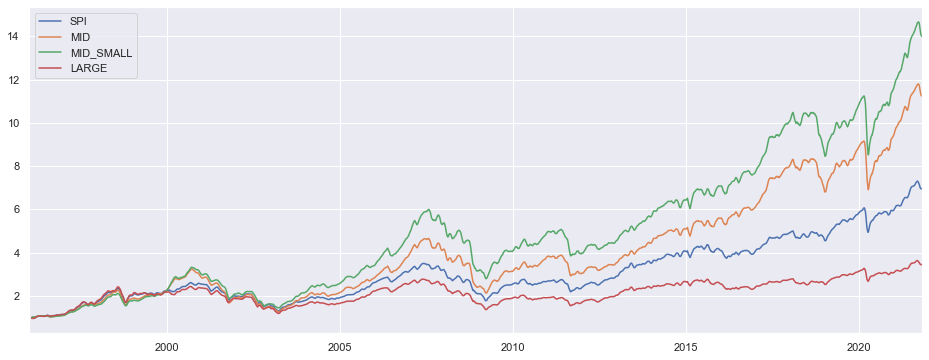

In [6]:
fig, ax = plt.subplots(figsize=(16,6))
(indices_price_excel.pct_change() + 1).cumprod().rolling(20).mean().plot(ax=ax)
plt.show()

In [7]:
mom12 = price.pct_change(periods=21 * 12)
mom6 = price.pct_change(periods=21 * 6)
mom1 = price.pct_change(periods=21 * 1)

ma200 = np.log(price / price.rolling(window=200).mean())
ma100 = np.log(price / price.rolling(window=100).mean())
ma50 = np.log(price / price.rolling(window=50).mean())

vol12 = price.rolling(window=21 * 12).std()
vol6 = price.rolling(window=21 * 6).std()
vol1 = price.rolling(window=21 * 1).std()

In [8]:
ema_12 = price.ewm(span=10).mean()
ema_26 = price.ewm(span=60).mean()
MACD = ema_12 - ema_26

In [9]:
def RSI(price, window):
    price_diff = price.diff()
    gain = price_diff.mask(price_diff < 0, 0.0)
    loss = - price_diff.mask(price_diff > 0, -0.0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 1 - 1 / (1 + rs)
    return rsi

In [10]:
RSI14 = RSI(price, 14)
RSI9 = RSI(price, 9)
RSI3 = RSI(price, 3)

In [11]:
df_dict = {}
df_X = pd.DataFrame()
for col in price.columns:
    df_temp = pd.concat([ma50[col], ma100[col], ma200[col],
                         mom12[col], mom6[col], mom1[col],
                         vol12[col], vol6[col], vol1[col],
                         RSI14[col], RSI9[col], RSI3[col], 
                         MACD[col]], axis=1).loc['1997-01-01':].fillna(method='ffill')
    df_temp.columns = ['ma50', 'ma100', 'ma200', 'mom12', 'mom6', 'mom1', 
                       'vol12', 'vol6', 'vol1', 'RSI14', 'RSI9', 'MACD', 'RSI3']
    df_dict[col] = df_temp
    
df_X = pd.concat(df_dict, axis=1)

In [31]:
df_X.head(5)

MID                                                    \
                ma50     ma100     ma200     mom12      mom6      mom1   
1997-01-01  0.022466  0.038097  0.040318  0.107268  0.033299  0.015894   
1997-01-02  0.021632  0.037319  0.040097  0.106482  0.032779  0.018607   
1997-01-03  0.025088  0.040894  0.044240  0.111435  0.036276  0.021194   
1997-01-06  0.029491  0.045517  0.049446  0.115450  0.046129  0.042128   
1997-01-07  0.031842  0.048303  0.052813  0.114716  0.054543  0.035250   

                                                       ...     LARGE  \
                vol12       vol6       vol1     RSI14  ...     mom12   
1997-01-01  54.359759  54.247790  16.733889  0.735158  ...  0.219023   
1997-01-02  54.301648  54.932420  17.434473  0.824030  ...  0.211196   
1997-01-03  54.307861  55.743792  18.829687  0.832718  ...  0.223900   
1997-01-06  54.440097  56.770481  18.087986  0.947918  ...  0.204432   
1997-01-07  54.703999  57.930561  19.846867  0.949648  ...  0.205896   

                                                                             \
                mom6      mom1       vol12        vol6       vol1     RSI14   
1997-01-01  0.044734  0.004510  184.851943  110.078930  33.052024  0.692056   
1997-01-02  0.040707  0.008081  184.295583  111.326139  34.950821  0.766167   
1997-01-03  0.034147  0.006720  183.372518  112.449337  36.425919  0.714199   
1997-01-06  0.036452  0.023022  182.636808  113.421332  35.193602  0.725153   
1997-01-07  0.044602  0.012623  181.813920  114.392678  35.576269  0.674269   

                                           
                RSI9      MACD       RSI3  
1997-01-01  0.768827  0.810559  66.997240  
1997-01-02  0.748332  0.000000  69.689354  
1997-01-03  0.849567  0.000000  71.091320  
1997-01-06  0.762136  0.000000  69.347797  
1997-01-07  0.755534  0.000000  67.420480  

[5 rows x 39 columns]

In [14]:
def strategie(df_input_all, price, rebalance_freq, model_name='MLP', nb_epochs=50, nb_epochs_first=200, input_period=8, month_test_period=5, training_window=5, mini_batch_size=1, verbose=0):
    
    first_end_date = '2002-02-01'
    num_tickers = len(df_input_all.columns.get_level_values(0).unique())
    num_features = len(df_input_all.columns.get_level_values(1).unique())
    
    returns = price.pct_change().shift(1).resample(rebalance_freq).agg(lambda x: (x + 1).prod() - 1)
    best_pred = returns.rank(axis=1).replace({1: 0., 2: 0., 3: 1.}).shift(-1).loc['1997-01-31':]
    
    prob_output = []
    pred_output = []
    
    if rebalance_freq == 'M':
        # The moving window every 6 month
        all_end_dates = best_pred.loc[first_end_date:].asfreq('6M', method='ffill').index
    else:
        # The moving window every 26 weeks
        all_end_dates = best_pred.loc[first_end_date:].asfreq('W-FRI', method='ffill')[::26].index
    
    for i, end_date in enumerate(tqdm(all_end_dates)):

        start_date = end_date - relativedelta(years=training_window)
        
        # The first date input must before the first date output
        if rebalance_freq =='M':
            # Make sur the input period start the 1st of the month
            start_date_input = (start_date - relativedelta(weeks=input_period)).replace(day=1) 
        else:
            start_date_input = start_date - relativedelta(days=input_period)
            # Make sur the input period start a monday
            start_date_input = start_date_input - relativedelta(days=(start_date_input.weekday()))

        df_input = df_input_all.loc[start_date_input:end_date]
        df_output = best_pred.loc[start_date:end_date]

        X = []
        for idx in df_output.index:
            # If we rebalance monthly, the input data will be weekly data
            if rebalance_freq == 'M':
                df_input_period = df_input.loc[:idx].asfreq('W', method='ffill').iloc[-input_period:]
            # If we rebalance weekly, the input data will be daily data
            else:
                df_input_period = df_input.loc[:idx].iloc[-input_period:]
                
            X_period = df_input_period.values.reshape(input_period, num_tickers, num_features)
            X.append(X_period)

        X = np.array(X)
        y = df_output.values
        
        # Find the first prediction date
        if i == 0:
            if rebalance_freq == 'M':
                first_start_date_test = end_date - relativedelta(months=5)
            else:
                first_start_date_test = end_date - relativedelta(weeks=25)
        
        if rebalance_freq == 'M':
            start_date_test = (end_date - relativedelta(months=5))
            # Make sur the first test date is the end of the month
            year_test, month_test = start_date_test.year, start_date_test.month
            start_date_test = start_date_test.replace(day=calendar.monthrange(year_test, month_test)[1])
            split_index = df_output.index.get_loc(start_date_test)    
        else:
            start_date_test = end_date - relativedelta(weeks=25)
            # Make sur the first test date is a friday
            delta_days = 4 - start_date_test.weekday()
            if delta_days < 0:
                delta_days += 7
            start_date_test = start_date_test + relativedelta(days=delta_days)
            split_index = df_output.index.get_loc(start_date_test)  
        
        # Create train and test set
        X_train, y_train = X[:split_index], y[:split_index]
        X_test, y_test = X[split_index:], y[split_index:]
        
        # Transform Numpy arrays to Torch tensors
        X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()
        
        # Standardize data within each feature 
        train_mean = X_train.mean(dim=[0, 1, 2], keepdim=True)
        train_std = X_train.std(dim=[0, 1, 2], keepdim=True)
        X_train = X_train.sub_(train_mean).div_(train_std)
    
        test_mean = X_test.mean(dim=[0, 1, 2], keepdim=True)
        test_std = X_test.std(dim=[0, 1, 2], keepdim=True)
        X_test = X_test.sub_(test_mean).div_(test_std)

        # # Shuffle Data
        # train_size = X_train.size(0)
        # shuffle_idx = torch.randperm(train_size)
        # X_train = X_train[shuffle_idx, :, :]
        # y_train = y_train[shuffle_idx, :]
        
        # Initialize ML models only at first iteration
        dim1, dim2, dim3 = X_train.size(1), X_train.size(2), X_train.size(3)
        if i == 0:
            if model_name == 'MLP':
                model = MLP(dim1, dim2, dim3)
            elif model_name == 'ConvNet':
                model = ConvNet(dim1, dim2, dim3)
            elif model_name == 'LSTM':
                model = LSTM(input_size=num_tickers * num_features, output_size=num_tickers, 
                             hidden_size=hidden_size, num_layers=num_layers)
        
        # More epochs needed for the first iteration 
        if i == 0:
            nb_epochs_all = nb_epochs_first
        else:
            nb_epochs_all = nb_epochs
        
        # Train the model
        train(model, X_train, y_train, nb_epochs_all, i, verbose=verbose, X_test=X_test, y_test=y_test)

        # Get predictions
        prob, pred = test(model, X_test, y_test)
        pred_output.append(pred)
        prob_output.append(prob)

    pred_output = np.array(pred_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
    df_pred = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=pred_output, columns=best_pred.columns)
    prob_output = np.array(prob_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
    df_prob = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=prob_output, columns=best_pred.columns)
    
    return df_pred, df_prob

  0%|          | 0/40 [00:00<?, ?it/s]

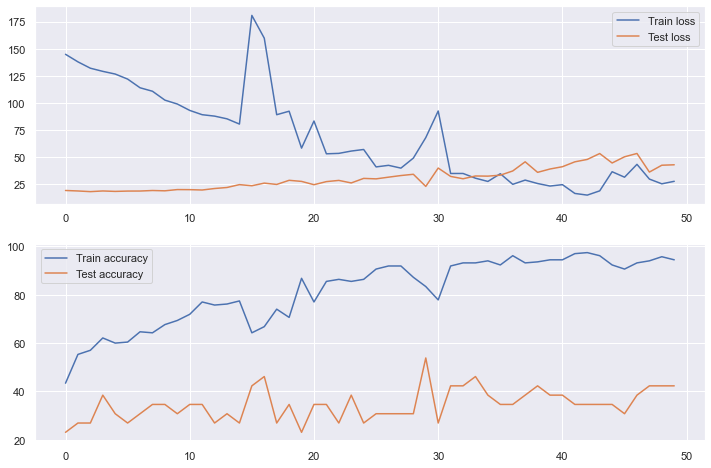

  2%|▎         | 1/40 [00:09<06:21,  9.77s/it]

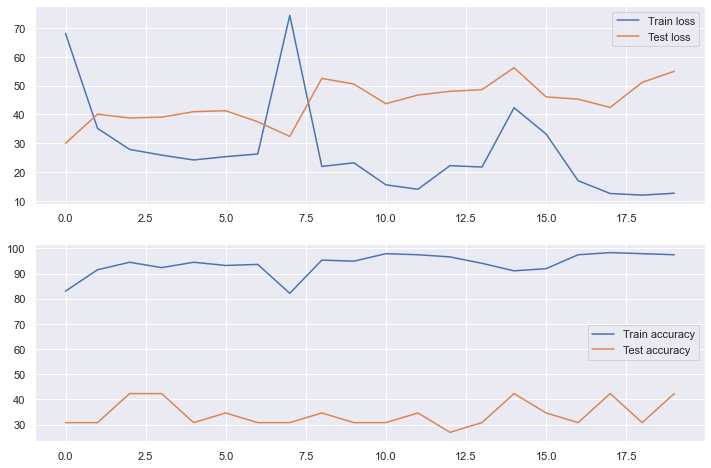

  0%|          | 0/40 [00:00<?, ?it/s]

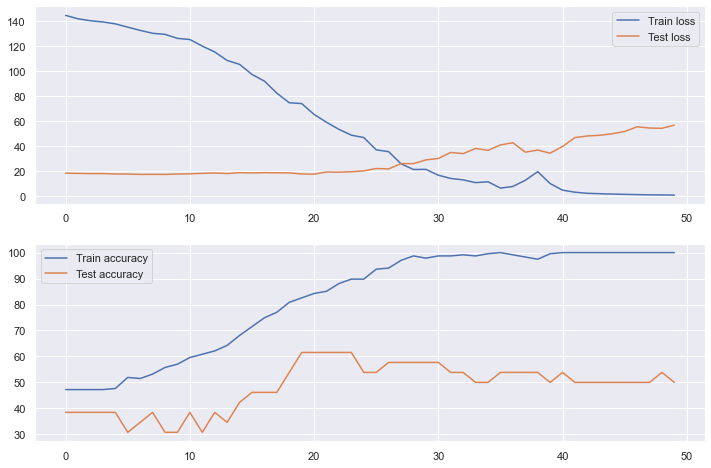

  2%|▎         | 1/40 [00:18<11:48, 18.16s/it]

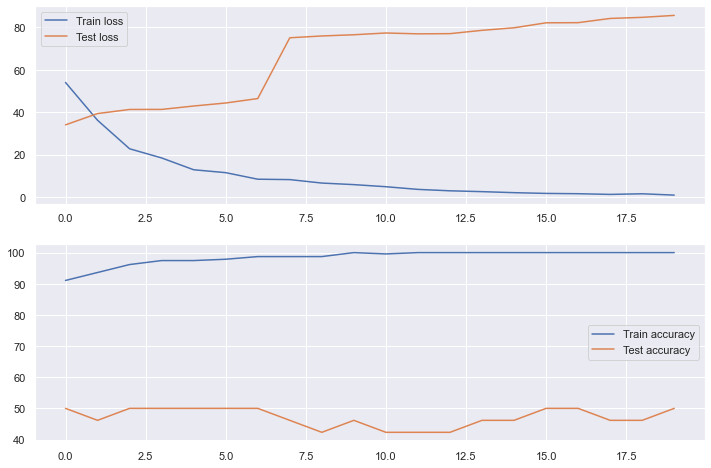

100%|██████████| 40/40 [05:25<00:00,  8.15s/it]


In [32]:
# models_list = ['MLP', 'ConvNet', 'LSTM']
models_list = ['MLP', 'ConvNet']

df_pred_dict = {}
df_prob_dict = {}
perf_pred_dict_gross = {}
perf_pred_dict_net = {}

input_period = 15
mini_batch_size = 5
verbose = 1
training_window = 5
nb_epochs_first = 50
nb_epochs = 20
rebalance_freq = 'W-FRI'

for i, model_name in enumerate(models_list):
    df_pred_dict[model_name], df_prob_dict[model_name] = strategie(df_input_all=df_X, price=price, rebalance_freq=rebalance_freq, 
                                                                   model_name=model_name, nb_epochs=nb_epochs, 
                                                                   nb_epochs_first=nb_epochs_first, input_period=input_period, 
                                                                   mini_batch_size=mini_batch_size, verbose=verbose, 
                                                                   training_window=training_window)
    
    perf_pred_dict_gross[model_name] = pred_to_perf(df_pred_dict[model_name], daily_returns)
    perf_pred_dict_net[model_name] = pred_to_perf(df_pred_dict[model_name], daily_returns, 0.0012)
    
    if i == 0:
        df_prob_ensemble = df_prob_dict[model_name].copy()
    else:
        df_prob_ensemble += df_prob_dict[model_name]

df_prob_ensemble /= len(models_list)
df_pred_dict['Ensemble'] = df_prob_ensemble.rank(axis=1).replace({1: 0., 2: 0., 3: 1.})

In [33]:
perf_bench = price_to_perf(bench_price.loc[df_pred_dict[model_name].index[0]:df_pred_dict[model_name].index[-1]], log=False)
perf_bench_log = price_to_perf(bench_price.loc[df_pred_dict[model_name].index[0]:df_pred_dict[model_name].index[-1]], log=True)

In [34]:
bench_stats = perf_to_stat(perf_bench, perf_bench)
stats = []
stats.append(bench_stats + [0])
for model_name in df_pred_dict.keys():
    
    perf_gross = pred_to_perf(df_pred_dict[model_name], daily_returns, 0.)
    perf_net = pred_to_perf(df_pred_dict[model_name], daily_returns, 0.0012)
    
    turnover_num = turnover(df_pred_dict[model_name])
    stats.append(perf_to_stat(perf_gross, perf_net) + [turnover(df_pred_dict[model_name])])
stats = np.array(stats)

df_stats = pd.DataFrame(data=stats, columns=['Gross avg. annual return (%)', 'Net avg. annual return (%)', 
                                             'Avg. annual vol. (%)', 'Avg Sharpe ratio', 
                                             'Max. Drawdown (%)', 'Turnover'], 
                        index=['Benchmark SPI'] + list(df_pred_dict.keys())).round(2)

df_stats.Turnover = df_stats.Turnover.apply(int)
df_stats

,Gross avg. annual return (%),Net avg. annual return (%),Avg. annual vol. (%),Avg Sharpe ratio,Max. Drawdown (%),Turnover
Benchmark SPI,7.35,7.35,17.41,0.42,44.52,0
MLP,8.19,4.86,16.57,0.29,43.89,551
ConvNet,9.60,6.08,17.04,0.36,43.06,575
Ensemble,8.88,5.52,16.83,0.33,45.97,558


In [35]:
df = pd.DataFrame(index=models_list, columns=models_list)
for comb in itertools.product(models_list, repeat=2):
    model1 = comb[0]
    model2 = comb[1]
    df.loc[model1][model2] = correlation(df_pred_dict[model1], df_pred_dict[model2])
df = df.astype(float)
df.round(2)

,MLP,ConvNet
MLP,1.00,0.44
ConvNet,0.44,1.00


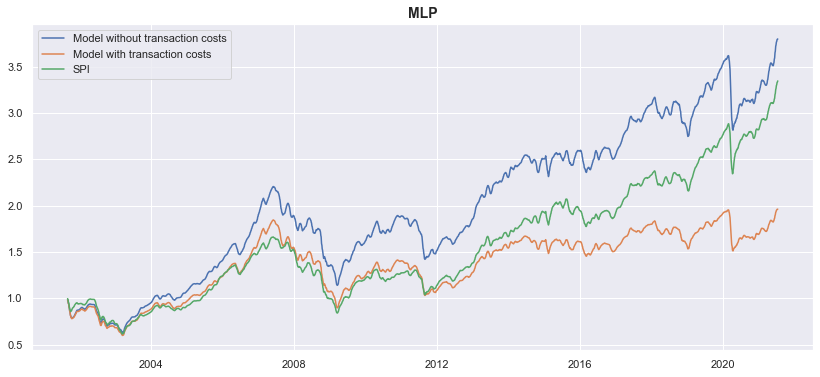

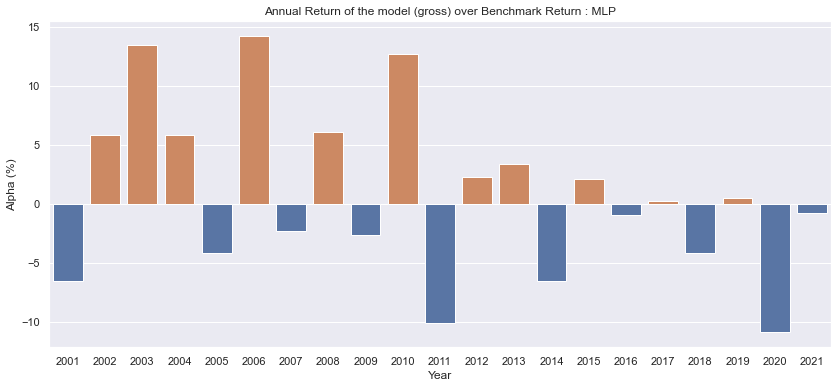

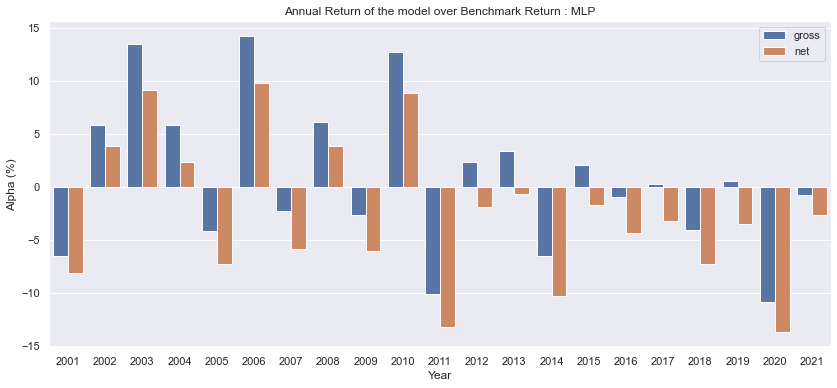

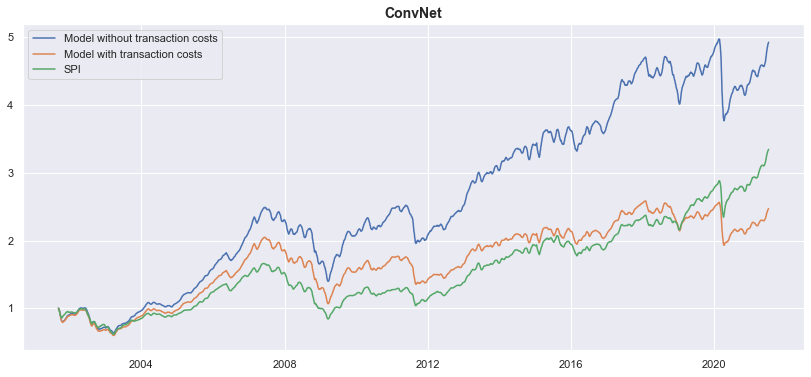

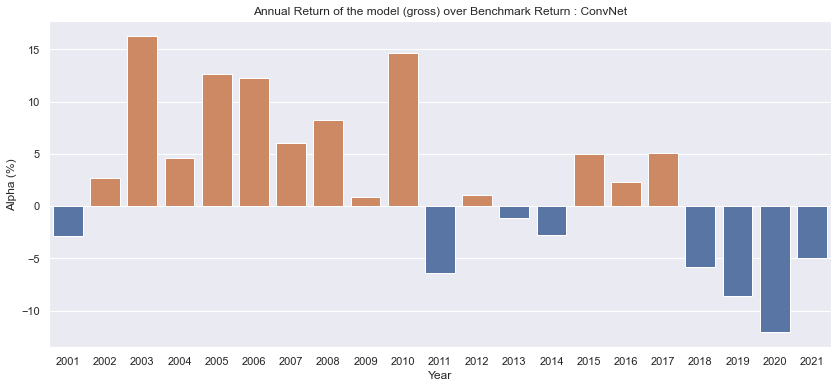

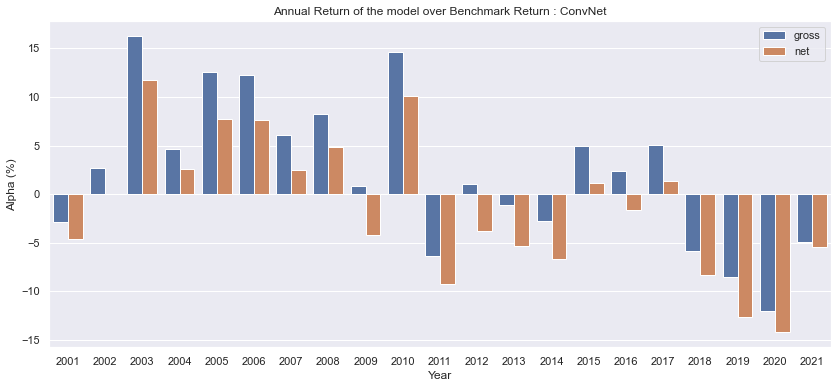

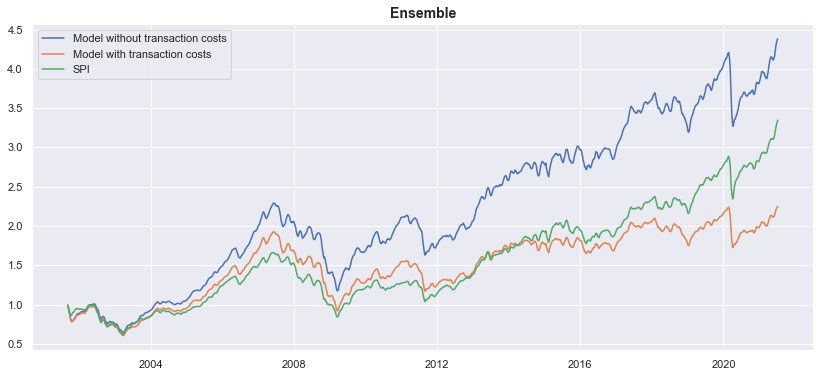

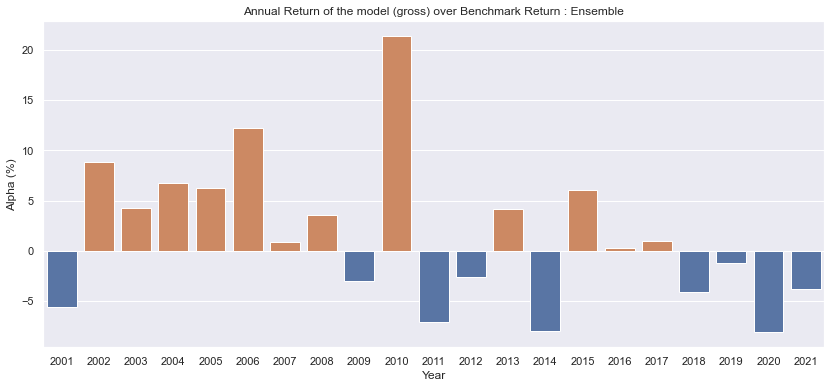

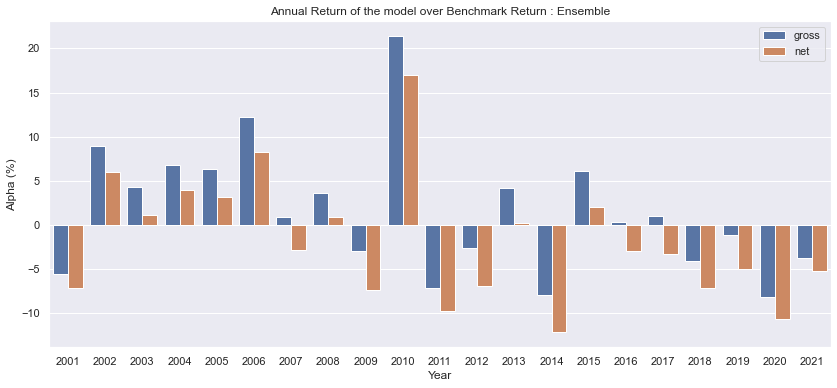

In [38]:
for model_name in df_pred_dict.keys():
    performance_plot(df_pred_dict[model_name], model_name, daily_returns, bench_price)
    annual_alpha_plot(perf_bench, df_pred_dict[model_name], model_name, daily_returns)
    annual_alpha_plot_grossnet(perf_bench, df_pred_dict[model_name], model_name, daily_returns)

In [47]:
dim2

3

In [45]:
rebalance_freq = 'W-FRI'
first_end_date = '2002-02-01'
model_name = 'MLP'
df_input_all = df_X
num_tickers = len(df_input_all.columns.get_level_values(0).unique())
num_features = len(df_input_all.columns.get_level_values(1).unique())

returns = price.pct_change().shift(1).resample(rebalance_freq).agg(lambda x: (x + 1).prod() - 1)
best_pred = returns.rank(axis=1).replace({1: 0., 2: 0., 3: 0., 4: 1.}).shift(-1).loc['1997-01-31':]

# ML parameters
pdrop = 0.25
eta = 1e-3

# LSTM parameters
hidden_size = 30
num_layers = 5

prob_output = []
pred_output = []
if rebalance_freq == 'M':
    all_end_dates = best_pred.loc[first_end_date:].asfreq('6M', method='ffill').index
else:
    all_end_dates = best_pred.loc[first_end_date:].asfreq('W-FRI', method='ffill')[::26].index
    
input_period = 8
nb_epochs_first = 5
nb_epochs = 1
verbose = 0

for i, end_date in enumerate(tqdm(all_end_dates)):
    
    start_date = end_date - relativedelta(years=training_window)
    
    if rebalance_freq =='M':
        start_date_input = (start_date - relativedelta(weeks=input_period)).replace(day=1) 
    else:
        start_date_input = (start_date - relativedelta(days=input_period))
        start_date_input = start_date_input - relativedelta(days=(start_date_input.weekday()))
        
    df_input = df_input_all.loc[start_date_input:end_date]
    df_output = best_pred.loc[start_date:end_date]

    X = []
    
    for idx in df_output.index:
        if rebalance_freq == 'M':
            df_input_period = df_input.loc[:idx].asfreq('W', method='ffill').iloc[-input_period:]
        else:
            df_input_period = df_input.loc[:idx].iloc[-input_period:]
            
        X_period = df_input_period.values.reshape(input_period, num_tickers, num_features)
        X.append(X_period)
        
    X = np.array(X)
    y = df_output.values
    
    if i == 0:
        #first_start_date_test = end_date.replace(day=31, month=1)
        if rebalance_freq == 'M':
            first_start_date_test = end_date - relativedelta(months=5)
        else:
            first_start_date_test = end_date - relativedelta(weeks=25)

    # start_date_test = end_date.replace(day=31, month=1)
    if rebalance_freq == 'M':
        start_date_test = (end_date - relativedelta(months=5))
        year_test, month_test = start_date_test.year, start_date_test.month
        start_date_test = start_date_test.replace(day=calendar.monthrange(year_test, month_test)[1])
        split_index = df_output.index.get_loc(start_date_test)    
    else:
        start_date_test = end_date - relativedelta(weeks=25)
        day_test = start_date_test.day
        delta_days = 4 - start_date_test.weekday()
        if delta_days < 0:
            delta_days += 7

        start_date_test = start_date_test + relativedelta(days=delta_days)
        split_index = df_output.index.get_loc(start_date_test)  

        
    X_train, y_train = X[:split_index], y[:split_index]
    X_test, y_test = X[split_index:], y[split_index:]
    X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()
    
    train_mean = X_train.mean(dim=[0, 1, 2], keepdim=True)
    train_std = X_train.std(dim=[0, 1, 2], keepdim=True)
    X_train = X_train.sub_(train_mean).div_(train_std)

    #train_size = X_train.size(0)
    #shuffle_idx = torch.randperm(train_size)
    #X_train = X_train[shuffle_idx, :, :]
    #y_train = y_train[shuffle_idx, :]

    test_mean = X_test.mean(dim=[0, 1, 2], keepdim=True)
    test_std = X_test.std(dim=[0, 1, 2], keepdim=True)
    X_test = X_test.sub_(test_mean).div_(test_std)

    # Model
    dim1, dim2, dim3 = X_train.size(1), X_train.size(2), X_train.size(3)

    if i == 0:
        if model_name == 'MLP':
            model = MLP(dim1, dim2, dim3, pdrop=pdrop)
        elif model_name == 'ConvNet':
            model = ConvNet(dim1, dim2, dim3, pdrop=pdrop)
        elif model_name == 'LSTM':
            model = LSTM(input_size=num_tickers * num_features, output_size=num_tickers, 
                         hidden_size=hidden_size, num_layers=num_layers)

    optimizer = torch.optim.Adam(model.parameters(), lr=eta)
    criterion = nn.BCELoss()

    train_accu_list = []
    train_loss_list = []
    test_accu_list = []
    test_loss_list = []

    if i == 0:
        nb_epochs_all = nb_epochs_first
    else:
        nb_epochs_all = nb_epochs

    for e in range(nb_epochs_all):
        acc_loss = 0
        model.train()
        for b in range(0, X_train.size(0), mini_batch_size):
            optimizer.zero_grad()
            output = model(X_train.narrow(0, b, mini_batch_size))
            loss = criterion(output, y_train.narrow(0, b, mini_batch_size))
            acc_loss = acc_loss + loss.item()
            loss.backward()
            optimizer.step()

        model.eval()
        train_accu = output_to_accu(model, X_train, y_train)
        train_accu_list.append(train_accu)
        test_accu = output_to_accu(model, X_test, y_test)
        test_accu_list.append(test_accu)

        train_loss = output_to_loss(model, X_train, y_train).detach().numpy()
        train_loss_list.append(train_loss)
        test_loss = output_to_loss(model, X_test, y_test).detach().numpy()
        test_loss_list.append(test_loss)

        #if verbose == 1:
        #    if (e % 5) == 0:
        #        print('epoch', e + 1, ':', acc_loss)

    if verbose == 1:
        if i in (0,1):
            fig, axs = plt.subplots(2, 1, figsize=(12,8))
            axs[0].plot(list(range(nb_epochs_all)), train_loss_list, label='Train loss')
            axs[0].plot(list(range(nb_epochs_all)), test_loss_list, label='Test loss')
            axs[0].legend()
            axs[1].plot(list(range(nb_epochs_all)), train_accu_list, label='Train accuracy')
            axs[1].plot(list(range(nb_epochs_all)), test_accu_list, label='Test accuracy')
            axs[1].legend()
            plt.suptitle(model_name + ' ' + end_date.date().strftime(format='%b %Y'))
            plt.show()

    model.eval()
    pred = np.zeros((X_test.size(0), y_test.size(1)))
    output_list = []
    for b in range(0, X_test.size(0)):
        output = model(X_test.narrow(0, b, 1))
        _, pred_index = output.max(1)
        pred[b, pred_index.item()] = 1
        output_list.append(output.detach().numpy())
    prob_output.append(np.array(output_list))
    pred_output.append(pred)

pred_output = np.array(pred_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
df_pred = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=pred_output, columns=best_pred.columns)
prob_output = np.array(prob_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
df_prob = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=prob_output, columns=best_pred.columns)

  0%|          | 0/40 [00:00<?, ?it/s]


ValueError: Using a target size (torch.Size([5, 3])) that is different to the input size (torch.Size([5, 4])) is deprecated. Please ensure they have the same size.

In [29]:
X_test.narrow(0,2,1).shape

torch.Size([1, 8, 4, 13])

In [31]:
X_test[1].shape

torch.Size([8, 4, 13])

In [289]:
13*4

52

In [255]:
np.array(pred_output).shape

(1040, 4)

In [198]:
df_input_period

SMIMC Index                                                    \
                  ma50     ma100     ma200     mom12      mom6      mom1   
1997-02-19    0.077851  0.120567  0.152865  0.231066  0.230399  0.075224   
1997-02-20    0.085823  0.129575  0.163052  0.248821  0.244280  0.074776   
1997-02-21    0.084053  0.129057  0.163657  0.254525  0.255181  0.064334   
1997-02-24    0.075065  0.121153  0.156731  0.243002  0.236193  0.054798   
1997-02-25    0.086097  0.133417  0.170060  0.260977  0.258780  0.068680   
1997-02-26    0.084328  0.132881  0.170575  0.273132  0.270432  0.064182   
1997-02-27    0.082360  0.132282  0.171030  0.258516  0.271219  0.066955   
1997-02-28    0.081035  0.132370  0.172172  0.253948  0.272036  0.069889   

                                                       ... SPI20 Index  \
                vol12       vol6       vol1     RSI14  ...       mom12   
1997-02-19  25.201960  30.088778  11.352655  0.933256  ...    0.330795   
1997-02-20  25.710226  30.699397  11.167376  0.942088  ...    0.339126   
1997-02-21  26.206232  31.260738  11.242494  0.939158  ...    0.326908   
1997-02-24  26.650047  31.762791  11.002015  0.849600  ...    0.246043   
1997-02-25  27.177340  32.364669  11.138112  0.877028  ...    0.268811   
1997-02-26  27.682657  32.913586  11.302316  0.876608  ...    0.294564   
1997-02-27  28.203786  33.444867  11.232107  0.837707  ...    0.276571   
1997-02-28  28.731309  33.968693  10.943913  0.820748  ...    0.261164   

                                                                              \
                mom6      mom1       vol12        vol6        vol1     RSI14   
1997-02-19  0.215748  0.124879  212.694710  214.463821  136.371213  0.916535   
1997-02-20  0.226995  0.100938  216.818999  220.862822  136.329866  0.901553   
1997-02-21  0.228073  0.086878  220.826879  226.625774  136.314082  0.874883   
1997-02-24  0.224035  0.081857  224.778603  230.557540  128.119556  0.728169   
1997-02-25  0.232358  0.091246  228.990424  235.093865  118.986932  0.749874   
1997-02-26  0.252518  0.085288  233.320016  239.738118  114.037537  0.767882   
1997-02-27  0.243657  0.083939  237.409639  243.809935  103.565084  0.702757   
1997-02-28  0.237242  0.066166  241.058823  246.964310   92.721753  0.627625   

                                            
                RSI9      MACD        RSI3  
1997-02-19  0.886421  0.780935  316.006225  
1997-02-20  0.865848  0.626562  320.166509  
1997-02-21  0.816682  0.828512  320.313154  
1997-02-24  0.608129  0.072702  309.682197  
1997-02-25  0.615712  0.375808  305.488682  
1997-02-26  0.679734  0.561066  305.579907  
1997-02-27  0.600144  0.797056  300.954117  
1997-02-28  0.447836  0.405780  290.715489  

[8 rows x 52 columns]

In [258]:
df_output.tail()

,SMIMC Index,SMCI Index,SPIEX Index,SPI20 Index
2021-06-11,0.0,0.0,0.0,1.0
2021-06-18,1.0,0.0,0.0,0.0
2021-06-25,0.0,0.0,0.0,1.0
2021-07-02,1.0,0.0,0.0,0.0
2021-07-09,0.0,1.0,0.0,0.0


In [257]:
end_date

Timestamp('2021-07-09 00:00:00', freq='26W-FRI')

In [119]:
start_date_test = (end_date - relativedelta(months=month_test_period))
print(start_date_test.date().weekday())
day_test = start_date_test.day
start_date_test = start_date_test.replace(day=day_test - (start_date_test.weekday() - 4))
print(start_date_test.date().weekday())

4
4


In [ ]:
start_date_test = (end_date - relativedelta(months=month_test_period))
year_test, month_test = start_date_test.year, start_date_test.month
start_date_test = start_date_test.replace(day=calendar.monthrange(year_test, month_test)[1])
split_index = df_output.index.get_loc(start_date_test)    
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]

In [99]:
start_date_test = (end_date - relativedelta(months=month_test_period))
start_date_test

Timestamp('2002-09-28 00:00:00', freq='6M')

In [82]:
year_test, month_test, week_test = start_date_test.year, start_date_test.month, start_date_test.week
start_date_test = start_date_test.replace(day=calendar.monthrange(year_test, month_test)[1])
start_date_test

Timestamp('2002-09-30 00:00:00', freq='6M')

In [100]:
start_date_test.date().weekday()

5

In [109]:
returns.resample('W-FRI').last().index[1].date().weekday()

4

In [89]:
calendar.weekrange(year_test, month_test, week_test)

AttributeError: module 'calendar' has no attribute 'weekrange'

In [113]:
best_pred

,SMIMC Index,SMCI Index,SPIEX Index,SPI20 Index
1997-02-02,0.0,0.0,0.0,1.0
1997-02-09,1.0,0.0,0.0,0.0
1997-02-16,0.0,0.0,0.0,1.0
1997-02-23,1.0,0.0,0.0,0.0
1997-03-02,0.0,1.0,0.0,0.0
...,...,...,...,...
2021-10-03,0.0,0.0,0.0,1.0
2021-10-10,0.0,0.0,1.0,0.0
2021-10-17,0.0,0.0,0.0,1.0
2021-10-24,0.0,1.0,0.0,0.0


In [112]:
df_X.head(10)

SMIMC Index                                                    \
                  ma50     ma100     ma200     mom12      mom6      mom1   
1997-01-01    0.021183  0.041832  0.037418  0.122313  0.031053  0.009178   
1997-01-02    0.020247  0.040893  0.037217  0.117781  0.031187  0.010355   
1997-01-03    0.030225  0.050985  0.048054  0.129028  0.042958  0.019935   
1997-01-06    0.035061  0.055928  0.053765  0.131691  0.056981  0.045572   
1997-01-07    0.042809  0.063860  0.062583  0.133435  0.070223  0.046394   
1997-01-08    0.054352  0.075665  0.075374  0.152582  0.103478  0.053748   
1997-01-09    0.056038  0.077784  0.078475  0.166060  0.116594  0.064430   
1997-01-10    0.053180  0.075289  0.076928  0.161219  0.116676  0.049433   
1997-01-13    0.065188  0.087865  0.090478  0.175322  0.132048  0.071509   
1997-01-14    0.061548  0.084724  0.088196  0.177523  0.144266  0.059179   

                                                       ... SPI20 Index  \
                vol12       vol6       vol1     RSI14  ...       ma200   
1997-01-01  15.053968  13.730276   3.227452  0.585078  ...    0.062232   
1997-01-02  15.005942  13.862270   3.385890  0.707792  ...    0.061825   
1997-01-03  14.992277  14.069762   4.003735  0.720844  ...    0.060896   
1997-01-06  15.008205  14.332086   4.299966  0.781789  ...    0.056387   
1997-01-07  15.079490  14.669200   5.272626  0.827436  ...    0.055787   
1997-01-08  15.198429  15.118869   6.902211  0.952399  ...    0.060924   
1997-01-09  15.304328  15.568567   8.074479  0.954594  ...    0.065831   
1997-01-10  15.407685  15.979529   9.071763  0.973387  ...    0.060627   
1997-01-13  15.588925  16.521204  10.421413  0.982497  ...    0.067230   
1997-01-14  15.739782  16.975392  11.472019  0.956546  ...    0.068742   

                                                                             \
               mom12      mom6      mom1       vol12        vol6       vol1   
1997-01-01  0.219023  0.044734  0.004510  184.851943  110.078930  33.052024   
1997-01-02  0.211196  0.040707  0.008081  184.295583  111.326139  34.950821   
1997-01-03  0.223900  0.034147  0.006720  183.372518  112.449337  36.425919   
1997-01-06  0.204432  0.036452  0.023022  182.636808  113.421332  35.193602   
1997-01-07  0.205896  0.044602  0.012623  181.813920  114.392678  35.576269   
1997-01-08  0.213853  0.072537  0.015314  181.058488  115.380969  37.183745   
1997-01-09  0.232122  0.084787  0.028152  180.116202  116.463640  38.953134   
1997-01-10  0.225406  0.081717  0.022642  179.015314  117.184352  38.901280   
1997-01-13  0.238011  0.085757  0.035475  177.952579  118.316387  38.534428   
1997-01-14  0.248230  0.117075  0.029567  176.684714  118.500060  40.126586   

                                           
               RSI14      RSI9       MACD  
1997-01-01  0.692056  0.768827  66.997240  
1997-01-02  0.766167  0.748332  69.689354  
1997-01-03  0.714199  0.849567  71.091320  
1997-01-06  0.725153  0.762136  69.347797  
1997-01-07  0.674269  0.755534  67.420480  
1997-01-08  0.706109  0.798253  68.771917  
1997-01-09  0.727164  0.732068  72.605636  
1997-01-10  0.709377  0.494857  72.404889  
1997-01-13  0.772282  0.652055  76.002015  
1997-01-14  0.781405  0.676020  79.602618  

[10 rows x 48 columns]

In [97]:
df_output.index[3].date().weekday()

6

In [98]:
df_output

,SMIMC Index,SMCI Index,SPIEX Index,SPI20 Index
1998-03-01,0.0,0.0,1.0,0.0
1998-03-08,1.0,0.0,0.0,0.0
1998-03-15,0.0,0.0,1.0,0.0
1998-03-22,0.0,0.0,0.0,1.0
1998-03-29,0.0,0.0,0.0,1.0
...,...,...,...,...
2003-01-26,0.0,0.0,0.0,1.0
2003-02-02,0.0,0.0,1.0,0.0
2003-02-09,1.0,0.0,0.0,0.0
2003-02-16,1.0,0.0,0.0,0.0


In [126]:
nb_errors = 0
mini_batch_size = 1
output_list = []
prediction_train = np.zeros((X_train.size(0), y_train.size(1)))
model.eval()

for b in range(0, X_train.size(0), mini_batch_size):
    output = model(X_train.narrow(0, b, mini_batch_size))
    output_list.append(output)
    _, predicted_classes = output.max(1)
    for k in range(mini_batch_size):
        prediction_train[b, predicted_classes[k]] = 1
        if y_train[b + k, predicted_classes[k]] != 1.:
            nb_errors = nb_errors + 1
    
print('accuracy on train set: {:0.2f}%'.format(100 - (100 * nb_errors) / X_train.size(0)))

accuracy on train set: 100.00%


In [131]:
nb_errors = 0
mini_batch_size = 1
output_list = []
prediction_test = np.zeros((X_test.size(0), y_test.size(1)))
prediction_rank = []
model.eval()

for b in range(0, X_test.size(0), mini_batch_size):
    output = model(X_test.narrow(0, b, mini_batch_size))
    output_list.append(output)
    prediction_rank.append(np.array(torch.sort(output)[1]).reshape(-1))
    _, predicted_classes = output.max(1)
    for k in range(mini_batch_size):
        prediction_test[b, predicted_classes[k]] = 1
        if y_test[b + k, predicted_classes[k]] != 1.:
            nb_errors = nb_errors + 1
prediction_rank = np.array(prediction_rank)
print('accuracy on test set: {:0.2f}%'.format(100 - (100 * nb_errors) / X_test.size(0)))

accuracy on test set: 28.57%


In [134]:
fig = plt.figure(figsize=(14,6))
df_pred = pd.DataFrame(data=prediction_test, columns=price.columns, index=best_pred[split_index:].index)
split_date = str(best_pred.iloc[split_index].name)
df_results_plot = pd.concat([pred_to_perf(best_pred[split_index:]), pred_to_perf(df_pred_convnet)], axis=1).rename(columns={0:'Best prediction', 1:'ConvNet'})
sns.lineplot(data=pd.concat([df_results_plot, price_to_perf(bench_price[split_date:])], axis=1))
plt.show()

ValueError: Shape of passed values is (21, 4), indices imply (247, 4)

<Figure size 1008x432 with 0 Axes>